In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cptsolver.fields import *
from cptsolver.utils import *
from cptsolver.plot import *
from cptsolver.integrators import *
from cptsolver.solver import *
from cptsolver.analyzer import *
from cptsolver.young import *

import pprint

from matplotlib import pyplot as plt

from datetime import datetime

We begin by grabbing the Tsyganenko model parameters from the dataset developed by Qin et al. (2007).

In [3]:
year = 2008
month = 3
day = 26
hour = 11
minute = 19

time = datetime(year, month, day, hour, minute)
parmod, ut, v_sw = get_txx_params('data/qindenton_03-26-2008', 'data/omni_03-26-2008', time)
b_field = t04(parmod, ut, v_sw)

Load IGRF coefficients ...


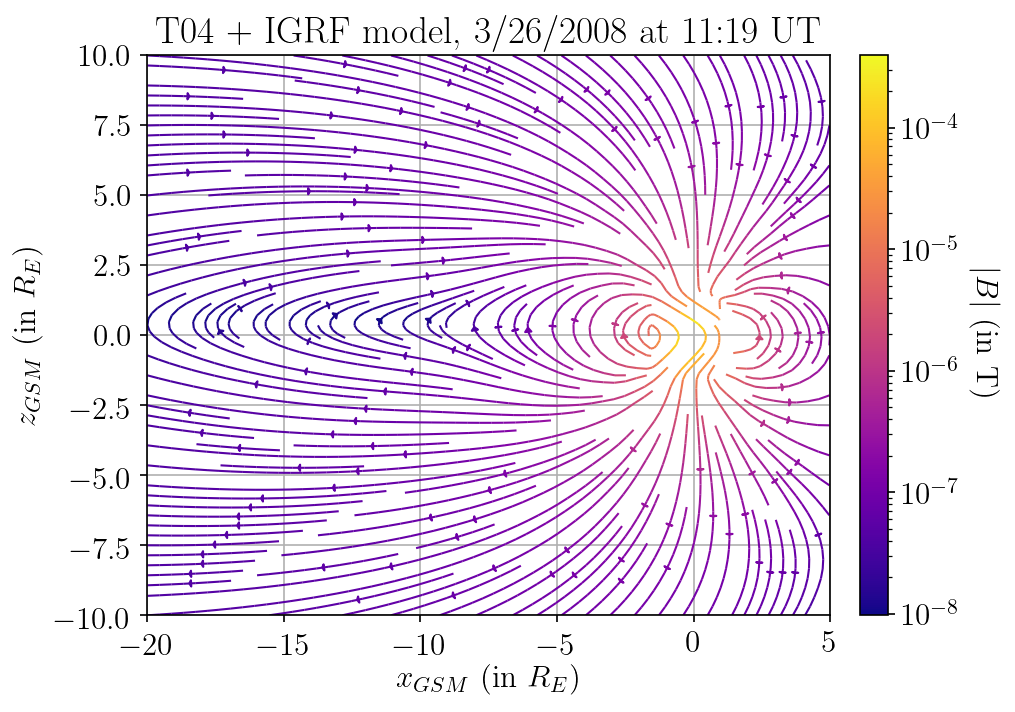

In [4]:
format_plots()
plot_field(b_field, np.array([1., 0., 0.]), np.array([0., 0., 1.]), [-20, 5], [-10, 10], size=(7, 5), labels=('$x_{GSM}$ (in $R_E$)', '$z_{GSM}$ (in $R_E$)', '$|B|$ (in T)'), title=f'T04 + IGRF model, {month}/{day}/{year} at {hour}:{minute} UT')

We next trace a field line at the specificed $L$ value along the midnight plane. After determining $\mathbf{B}$ along the field line, we calculate the $B_{\text{mirror}}$ and $B_0$.

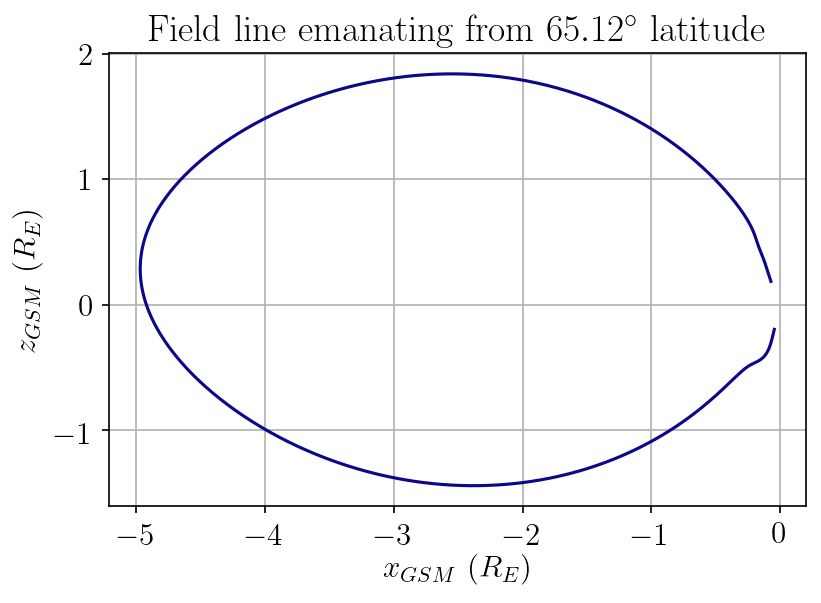

In [5]:
lat = np.radians(65.1200)
r = np.array([-Re * np.cos(lat), 0., Re * np.sin(lat)])
rr = field_line(b_field, r)

plt.plot(rr[:, 0] / Re, rr[:, 2] / Re)

plt.xlabel('$x_{GSM}$ ($R_E$)')
plt.ylabel('$z_{GSM}$ ($R_E$)')
plt.title('Field line emanating from $65.12^{\circ}$ latitude')

plt.grid()
plt.show()

In [6]:
E = 300e3

gamma = eV_to_J(E) / (sp.m_e * sp.c**2) + 1.
v = sp.c * np.sqrt(1. - 1. / gamma**2)

kappa = []
L_actual = []

for L in np.linspace(5, 10, 50):
    rr = field_line(b_field, np.array([-L * Re, 0., 0.]))
    r_mag = np.linalg.norm(rr, axis=1)
    cs_ind = r_mag.argmax()
    L_actual.append(r_mag[cs_ind] / Re)

    Rc = flc(b_field, rr[cs_ind], eps=1)
    rho = gamma * sp.m_e * v / (np.abs(-sp.e) * np.linalg.norm(b_field(rr[cs_ind])))
    kappa.append(np.sqrt(Rc / rho))

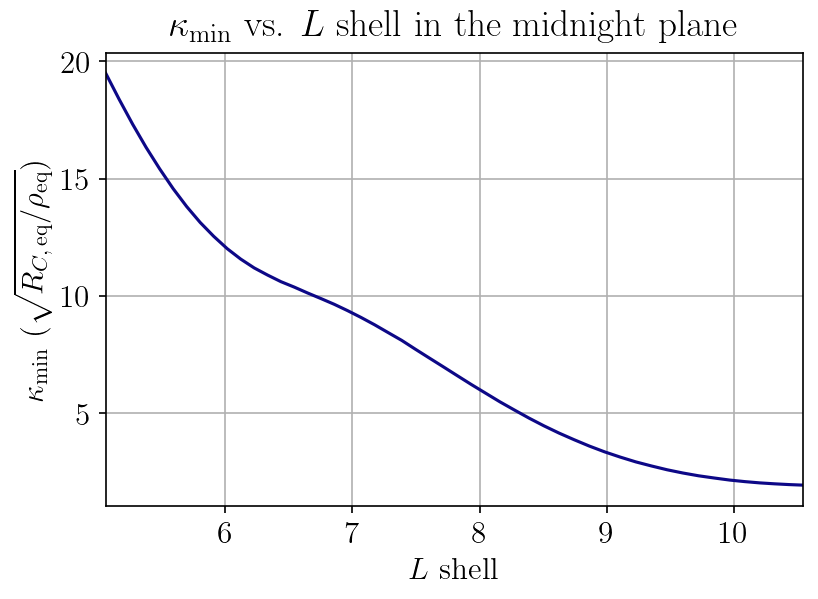

In [7]:
plt.plot(L_actual, kappa)

plt.xlabel('$L$ shell')
plt.ylabel('$\kappa_{\mathrm{min}}$ ($\sqrt{R_{C,\,\mathrm{eq}}/\\rho_{\mathrm{eq}}}$)')

plt.title('$\kappa_{\mathrm{min}}$ vs. $L$ shell in the midnight plane')
plt.xlim([L_actual[0], L_actual[-1]])

plt.grid()
plt.show()

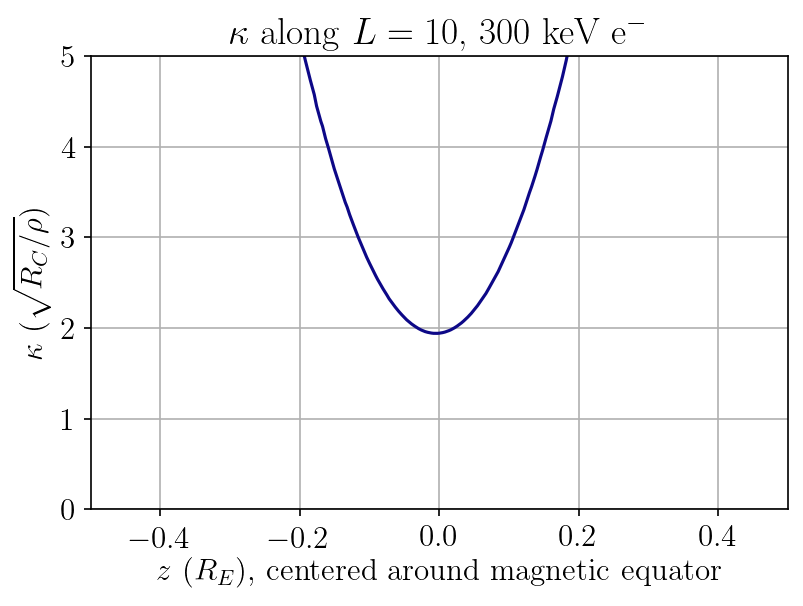

In [8]:
kappa = []

for r in rr:
    Rc = flc(b_field, r, eps=1)
    rho = gamma * sp.m_e * v / (np.abs(-sp.e) * np.linalg.norm(b_field(r)))
    kappa.append(np.sqrt(Rc / rho))
    
plt.plot((rr[:, 2] - rr[cs_ind, 2]) / Re, kappa)

plt.xlabel('$z$ ($R_E$), centered around magnetic equator')
plt.ylabel('$\kappa$ ($\sqrt{R_C/\\rho}$)')
plt.xlim([-0.5, 0.5])
plt.ylim([0, 5])
plt.title('$\kappa$ along $L = 10$, $300$ keV e$^-$')

plt.grid()
plt.show()

In [9]:
L = 9.52

rr = field_line(b_field, np.array([-L * Re, 0., 0.]))
L_actual = np.amax(np.linalg.norm(rr, axis=1)) / Re
print(f'The actual L-shell is {L_actual:.2f}.')

bv, bm, brm = b_along_path(b_field, rr)
cs_ind = bm.argmin()

b_mirror_south = bm[np.abs(np.linalg.norm(rr[0:cs_ind], axis=1) - (Re + 100e3)).argmin()]
b_mirror_north = bm[np.abs(np.linalg.norm(rr[cs_ind:], axis=1) - (Re + 100e3)).argmin() + cs_ind]

b0 = bm[cs_ind]
b_mirror = min(b_mirror_north, b_mirror_south)

eq_loss_cone_ang = np.arcsin(np.sqrt(bm[cs_ind] / b_mirror))
print(f'The equatorial loss cone angle is {np.degrees(eq_loss_cone_ang):.3f} degrees.')

The actual L-shell is 10.00.
The equatorial loss cone angle is 0.745 degrees.


We can compare the normalized bounce time between the Tsyganenko model and the usual expression valid in a dipole field.

In [10]:
T_alpha = normalized_bounce_time(b_field, L)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


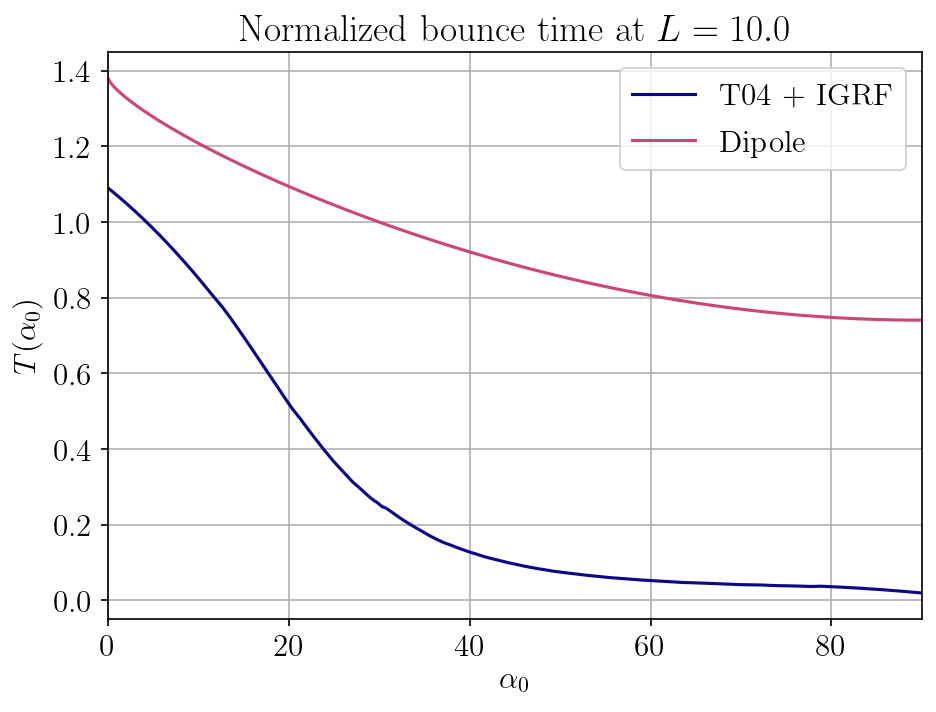

In [11]:
plt.figure(figsize=(7, 5))

alpha_eqs = np.radians(np.linspace(0, 90, 500))
plt.plot(np.degrees(alpha_eqs), T_alpha(alpha_eqs), label='T04 + IGRF')
plt.plot(np.degrees(alpha_eqs), T_dipole(alpha_eqs), label='Dipole', c='C7')
# plt.plot(np.degrees(alpha_eqs), T_alpha_test(alpha_eqs), label='Dipole + Harris', c='C10')

plt.xlim([0, 90])
plt.xlabel(r'$\alpha_0$')
plt.ylabel(r'$T(\alpha_0)$')
plt.title(f'Normalized bounce time at $L = {L_actual:.1f}$')

plt.legend()
plt.grid()
plt.show()

By guessing at the current sheet thickness $L_{cs}$, we generate the Harris model corresponding to the above Tsyganenko model.

In [12]:
z1, z2 = zetas_general(b_field, L)

sigma = np.sqrt((z1 - 3) / 2) # From z1
# sigma = z2 # From z2
# sigma = 0.93 # Manually

L_cs = flc(b_field, rr[cs_ind]) / sigma

b0x, sigma, L_cs = harris_params_from_txx(b_field, L, L_cs)
b_field_h = harris_cs_model(b0x, sigma, L_cs)

We can then examine the properties of this model and compare them to the Tsyganenko.

In [13]:
zsT = (rr[:, 2] - rr[cs_ind, 2]) / Re
flcT = np.zeros(len(bm))

for i in range(len(flcT)):
    flcT[i] = flc(b_field, rr[i], eps=10) / Re
    
N = 200
zs = np.linspace(-2, 2, N)

bm0 = np.zeros(N)
bm1 = np.zeros(N)

flc0 = np.zeros(N)
flc1 = np.zeros(N)

for i in range(N):
    bm0[i] = np.linalg.norm(b_field_h(np.array([0., 0., zs[i] * Re])))
    flc0[i] = flc(b_field_h, np.array([0., 0., zs[i] * Re]), eps=10) / Re
    
bh_v = np.zeros((300, 3))
zs_h = np.linspace(-2, 2, 300)

for i in range(300):
    bh_v[i] = b_field_h(np.array([0., 0., zs_h[i] * Re]))

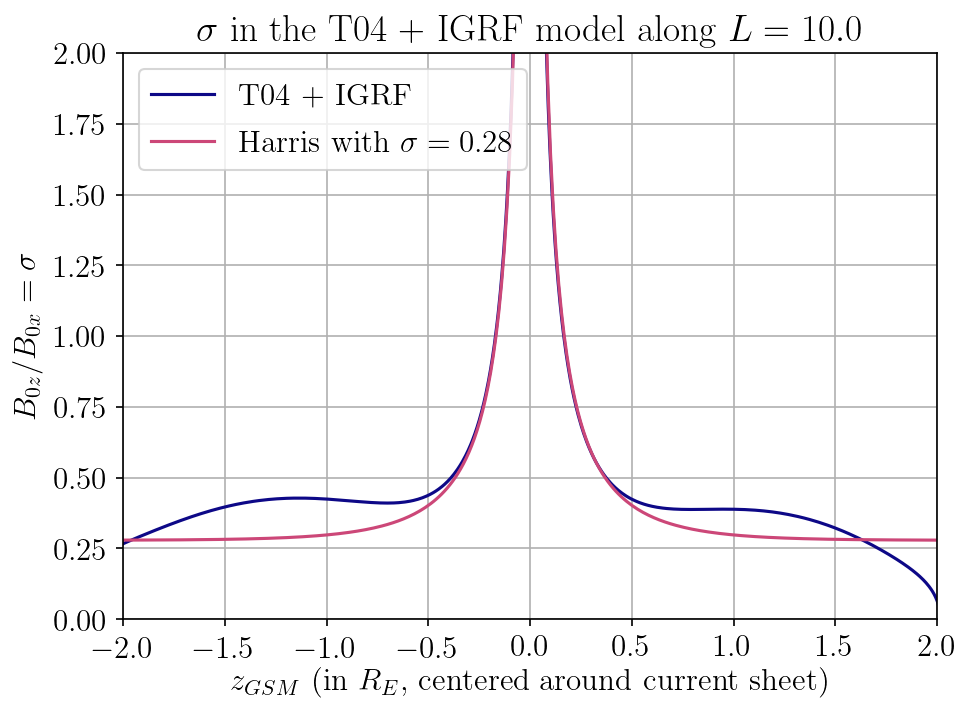

In [14]:
pad = 480
plt.figure(figsize=(7, 5))

plt.plot((rr[:, 2][pad:-pad] - rr[cs_ind, 2]) / Re, np.abs(bv[:, 2][pad:-pad] / bv[:, 0][pad:-pad]), label='T04 + IGRF')
plt.plot(zs_h, np.abs(bh_v[:, 2] / bh_v[:, 0]), c='C7', label=f'Harris with $\sigma={sigma:.2f}$')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylim([0, 2])
plt.ylabel(r'$B_{0z}/B_{0x} = \sigma$')
plt.title(f'$\sigma$ in the T04 + IGRF model along $L = {L_actual:.1f}$')

plt.legend()
plt.grid()
plt.show()

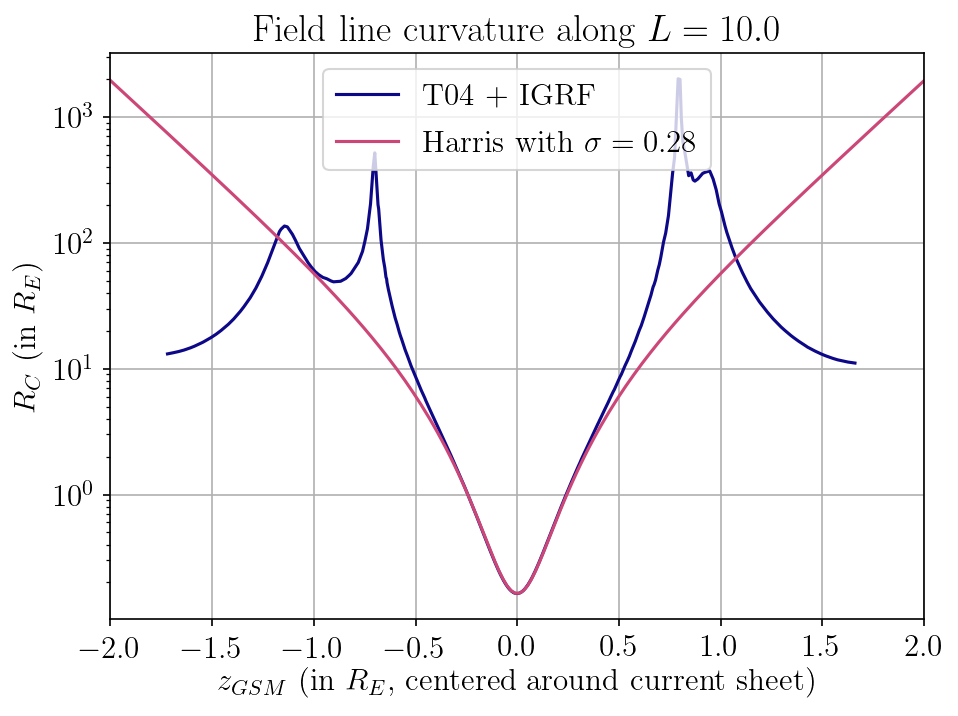

In [15]:
format_plots()
plt.figure(figsize=(7, 5))

plt.semilogy(zsT[cs_ind-200:cs_ind+200], flcT[cs_ind-200:cs_ind+200], label=r'T04 + IGRF', c='C0')    
plt.semilogy(zs, flc0, label=f'Harris with $\sigma={sigma:.2f}$', c='C7')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylabel('$R_C$ (in $R_E$)')
plt.title(f'Field line curvature along $L={L_actual:.1f}$')

plt.legend()
plt.grid()
plt.show()

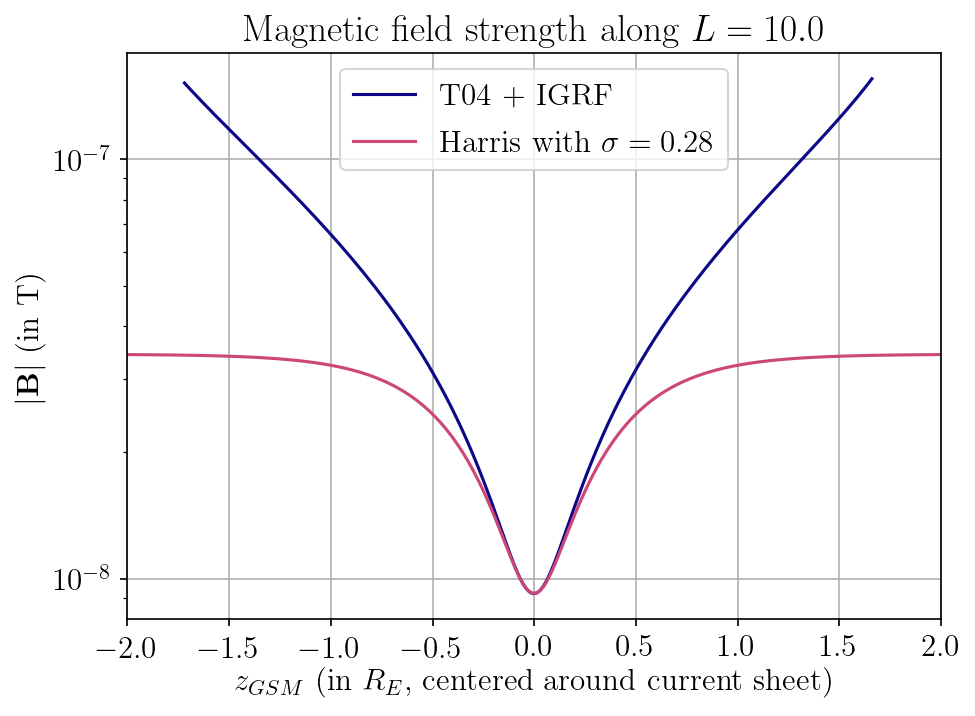

In [16]:
format_plots()
plt.figure(figsize=(7, 5))

plt.semilogy(zsT[cs_ind-200:cs_ind+200], bm[cs_ind-200:cs_ind+200], label=r'T04 + IGRF', c='C0')
plt.semilogy(zs, bm0, label=f'Harris with $\sigma={sigma:.2f}$', c='C7')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylabel('$|\mathbf{B}|$ (in T)')
plt.title(f'Magnetic field strength along $L={L_actual:.1f}$')

plt.legend()
plt.grid()
plt.show()

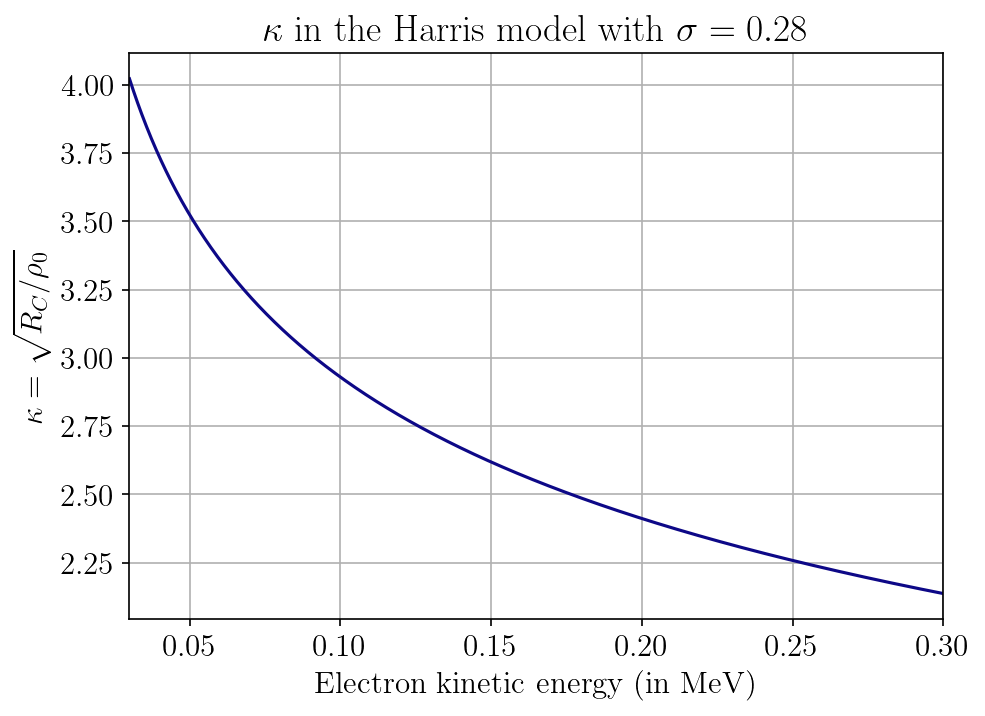

In [17]:
energies = np.linspace(30e3, 300e3, 1000)

def kappa_h(E):
    gamma = eV_to_J(E) / (sp.m_e * sp.c**2) + 1
    v = sp.c * np.sqrt(1 - 1 / gamma**2)
    return np.sqrt(np.abs(-sp.e) * sigma**2 * L_cs * b0x / (gamma * sp.m_e * v))

plt.figure(figsize=(7, 5))

plt.plot(energies * 1e-6, kappa_h(energies), c='C0')

plt.xlim([3e-2, 3e-1])
plt.xlabel('Electron kinetic energy (in MeV)')
plt.ylabel(r'$\kappa = \sqrt{R_C/ \rho_0}$')
plt.title(f'$\kappa$ in the Harris model with $\sigma = {sigma:.2f}$')

plt.grid()
plt.show()

Using the methods of Young et al. (2002) and Young et al. (2008), we may plot the bounce-averaged equatorial pitch angle diffusion coefficient $\langle D_{\alpha_0\alpha_0}\rangle$. We may then estimate the particle lifetime using $\tau = 1/\langle D_{\alpha_0\alpha_0}(\alpha_{LC})\rangle$.

Approximate lifetime of 30 keV particles: 2.32e+12 s
Approximate lifetime of 100 keV particles: 4.46e+08 s
Approximate lifetime of 200 keV particles: 5.20e+05 s
Approximate lifetime of 300 keV particles: 5.12e+04 s


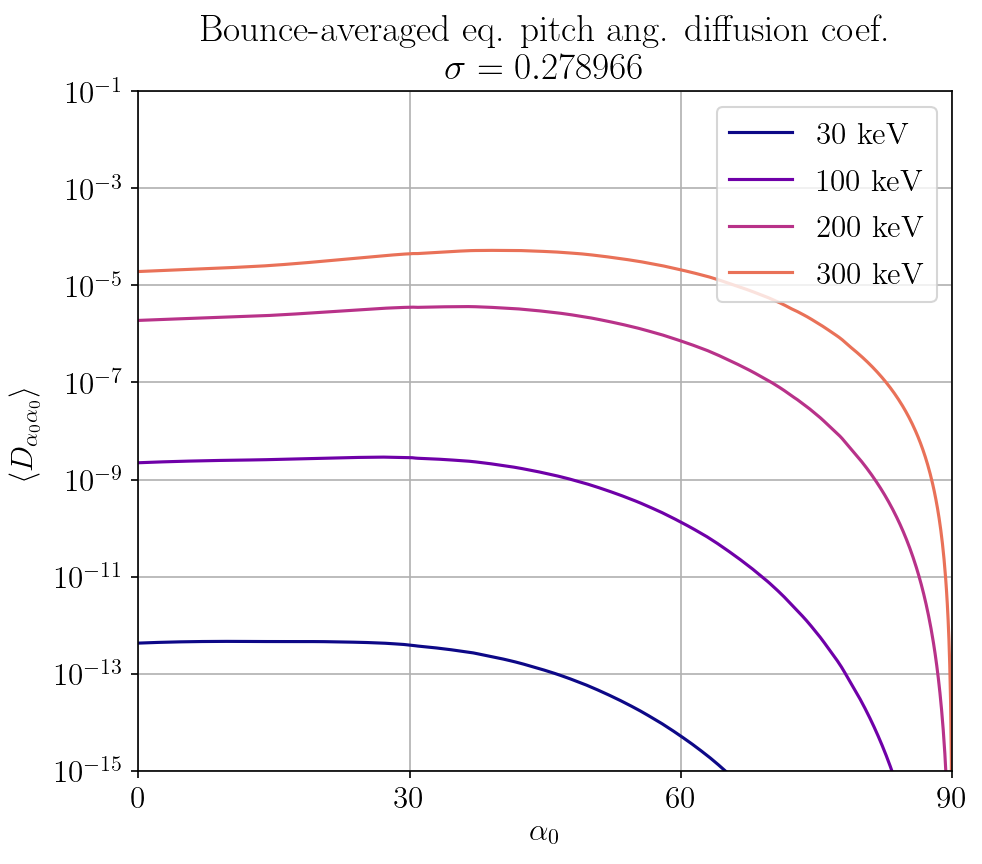

In [18]:
Es = [30, 100, 200, 300]
z1, z2 = zetas_harris(sigma)

steps = 1000
alpha_eqs = np.radians(np.linspace(1e-5, 90 - 1e-5, steps))

plt.figure(figsize=(7, 6))

for i in range(len(Es)):
    eps = epsilon_harris(Es[i] * 1e3, -sp.e, sp.m_e, b0x, sigma, L_cs)
    D_aas = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
    lifetime = 1 / D_aa(eps, z1, z2, eq_loss_cone_ang, T_alpha)
    print(f'Approximate lifetime of {Es[i]} keV particles: {lifetime:.2e} s')
    plt.semilogy(np.degrees(alpha_eqs), D_aas, c=f'C{3*i}', label=f'${Es[i]}$ keV')

plt.xlim([0, 90])
plt.xticks(np.linspace(0, 90, 4))
plt.xlabel(r'$\alpha_0$')
plt.ylim([1e-15, 1e-1])
plt.ylabel(r'$\langle D_{\alpha_0\alpha_0}\rangle$')
plt.title(f'Bounce-averaged eq. pitch ang. diffusion coef.\n$\sigma = {sigma:.6f}$')

plt.legend()
plt.grid()
plt.show()

We can do the same as above with the Tsyganenko model (as opposed to the Harris model).

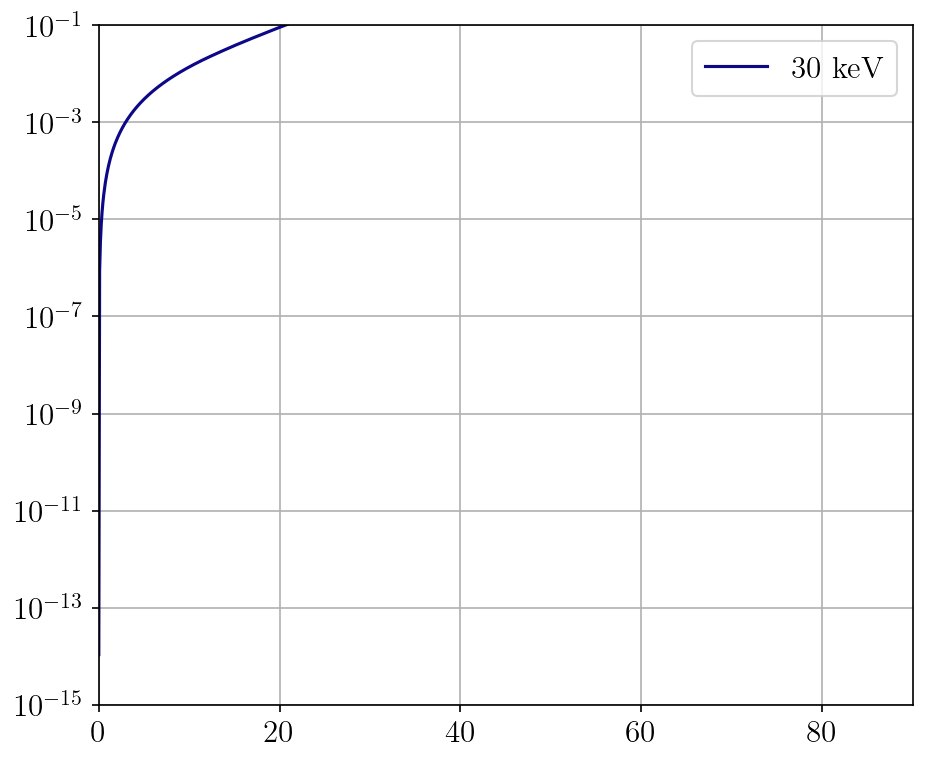

In [19]:
plt.figure(figsize=(7, 6))

E = 30e3
gamma = eV_to_J(E) / (sp.m_e * sp.c**2) + 1.
v = sp.c * np.sqrt(1. - 1. / gamma**2)

T_B = ((4 * Re * L_actual) / (v)) * T_alpha(alpha_eqs)
plt.semilogy(np.degrees(alpha_eqs), alpha_eqs**2 / T_B, label='$30$ keV')


plt.ylim([1e-15, 1e-1])
plt.xlim([0, 90])

plt.legend()
plt.grid()
plt.show()

In [20]:
Es = [30, 100, 200, 300]
z1, z2 = zetas_general(b_field, L)
R_c = flc(b_field, rr[cs_ind])

steps = 1000
alpha_eqs = np.radians(np.linspace(1e-5, 90 - 1e-5, steps))


0.061797492741619164
3.155644481273962 1.0461757733747892
Approximate lifetime of 30 keV particles: 2.15e+09 s
0.11651955394495969
3.155644481273962 1.0461757733747892
Approximate lifetime of 100 keV particles: 6.45e+04 s
0.1719701297742759
3.155644481273962 1.0461757733747892
Approximate lifetime of 200 keV particles: 1.80e+03 s
0.21906792839013828
3.155644481273962 1.0461757733747892
Approximate lifetime of 300 keV particles: 3.78e+02 s


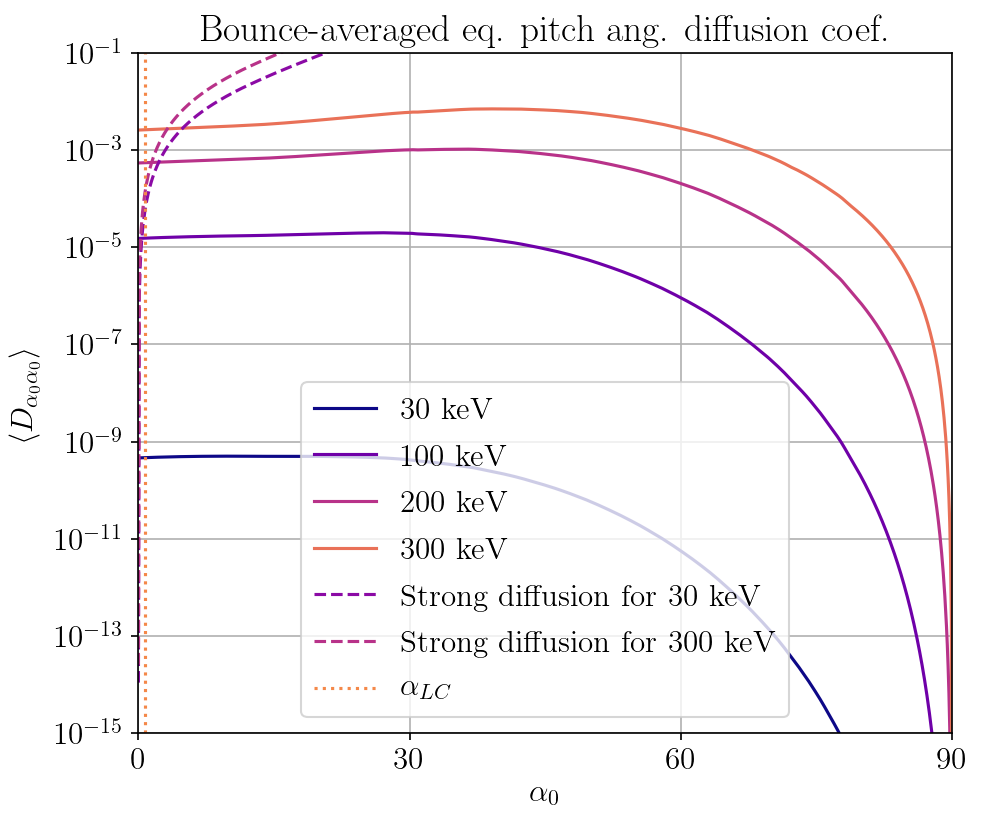

In [21]:
plt.figure(figsize=(7, 6))

for i in range(len(Es)):
    eps = epsilon_general(Es[i] * 1e3, -sp.e, sp.m_e, R_c, b0)
    print(eps)
    print(z1, z2)
    D_aas = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
    lifetime = 1 / D_aa(eps, z1, z2, eq_loss_cone_ang, T_alpha)
    print(f'Approximate lifetime of {Es[i]} keV particles: {lifetime:.2e} s')
    plt.semilogy(np.degrees(alpha_eqs), D_aas, c=f'C{3*i}', label=f'${Es[i]}$ keV')

E = 30e3
gamma = eV_to_J(E) / (sp.m_e * sp.c**2) + 1.
v = sp.c * np.sqrt(1. - 1. / gamma**2)

T_B = ((4 * Re * L_actual) / (v)) * T_alpha(alpha_eqs)
plt.semilogy(np.degrees(alpha_eqs), alpha_eqs**2 / T_B, linestyle='--', c='C4', label='Strong diffusion for $30$ keV')
    
E = 300e3
gamma = eV_to_J(E) / (sp.m_e * sp.c**2) + 1.
v = sp.c * np.sqrt(1. - 1. / gamma**2)

T_B = ((4 * Re * L_actual) / (v)) * T_alpha(alpha_eqs)
plt.semilogy(np.degrees(alpha_eqs), alpha_eqs**2 / T_B, linestyle='--', c='C6', label='Strong diffusion for $300$ keV')
    
plt.axvline(np.degrees(eq_loss_cone_ang), 0, 1, linestyle=':', c='C10', label='$\\alpha_{LC}$')

    
plt.xlim([0, 90])
plt.xticks(np.linspace(0, 90, 4))
plt.xlabel(r'$\alpha_0$')
plt.ylim([1e-15, 1e-1])
plt.ylabel(r'$\langle D_{\alpha_0\alpha_0}\rangle$')
plt.title('Bounce-averaged eq. pitch ang. diffusion coef.')

plt.legend()
plt.grid()
plt.show()

In [40]:
model = 0

In [63]:
s, r, b_spawn, pa = np.zeros(4)

if model == 0:
    # Full T04 + IGRF
    s = solver(zero_field(), b_field, higueracary)

    r = rr[cs_ind + 250]
    b_spawn = np.linalg.norm(b_field(r))
    pa = np.arcsin(np.sqrt(b_spawn / bm[cs_ind]) * np.sin(eq_loss_cone_ang))
elif model == 1:
    # Harris
    s = solver(uniform_field(1, np.array([0., 1., 0.])), b_field_h, higueracary)

    r = np.array([0., 0., -5 * Re])
    b_spawn = np.linalg.norm(b_field_h(r))
    pa = np.arcsin(np.sqrt(b_spawn / (sigma * b0x)) * np.sin(eq_loss_cone_ang))

In [48]:
# Populate

E = 300 # in keV

s.populate(
           1000,
           delta(r),
           delta(300 * E),
           delta(pa),
           np.linspace(0, 2 * np.pi, 1000),
           by_list=True
          )

100%|██████████| 1000/1000 [00:03<00:00, 310.72it/s]


In [12]:
# Solve

s.solve(1.5, 1e-4, 1e-3)

100%|██████████| 1000/1000 [07:12<00:00,  2.31it/s]


In [13]:
s.save(f'{E}kev_case_study')

Saved file 300kev_t04_case_study.hdf5 containing 95.35 megabytes of information.


In [28]:
a = analyzer(f'{E}kev_case_study')

Loaded file 300kev_t04_case_study.hdf5 containing 116.36 megabytes of information.


In [29]:
pas = a.pitch_ang()
rs = a.position()
vs = a.velocity()
ms = a.mass()
qs = a.charge()

In [31]:
crossing_ind_avg = 0

for i in range(1000):
    if model == 0:
        crossing_ind = np.linalg.norm(rs[i, 0:500], axis=1).argmax()
        crossing_ind_avg += crossing_ind
    elif model == 1:
        crossing_ind = pas[i, :].argmax()
        crossing_ind_avg += crossing_ind

crossing_ind_avg /= 1000
crossing_ind_avg = int(round(crossing_ind_avg))

In [32]:
b_min = 1e10

if model == 0:
    for i in range(1000):
        r_temp, b_temp = guiding_center(rs[i, crossing_ind_avg], vs[i, crossing_ind_avg], b_field, ms[i], qs[i])
        b_min_maybe = np.linalg.norm(b_temp)
        if b_min_maybe < b_min:
            b_min = b_min_maybe
elif model == 1:
    b_min = sigma * b0x

In [68]:
gca_points = np.zeros((1000, 2, 3))

for i in range(1000):
    if model == 0:
        r, gca_points[i, 0] = guiding_center(rs[i, 0], vs[i, 0], b_field, ms[i], qs[i])
        r, gca_points[i, 1] = guiding_center(rs[i, crossing_ind_avg * 2], vs[i, crossing_ind_avg * 2], b_field, ms[i], qs[i])
    elif model == 1:
        r, gca_points[i, 0] = guiding_center(rs[i, 0], vs[i, 0], b_field_h, ms[i], qs[i])
        r, gca_points[i, 1] = guiding_center(rs[i, crossing_ind_avg * 2], vs[i, crossing_ind_avg * 2], b_field_h, ms[i], qs[i])

In [69]:
norm_mom_bs = b_min / np.linalg.norm(gca_points, axis=2)

In [70]:
sin_pas_start = np.sin(np.arccos(np.sum(vs[:, 0] * gca_points[:, 0], axis=1) / (np.linalg.norm(vs[:, 0], axis=1) * np.linalg.norm(gca_points[:, 0], axis=1))))
sin_pas_end = np.sin(np.arccos(np.sum(vs[:, crossing_ind_avg * 2] * gca_points[:, 1], axis=1) / (np.linalg.norm(vs[:, crossing_ind_avg * 2], axis=1) * np.linalg.norm(gca_points[:, 1], axis=1))))

In [71]:
mu_initial = 0.5 * norm_mom_bs[:, 0] * sin_pas_start**2
mu_final = 0.5 * norm_mom_bs[:, 1] * sin_pas_end**2

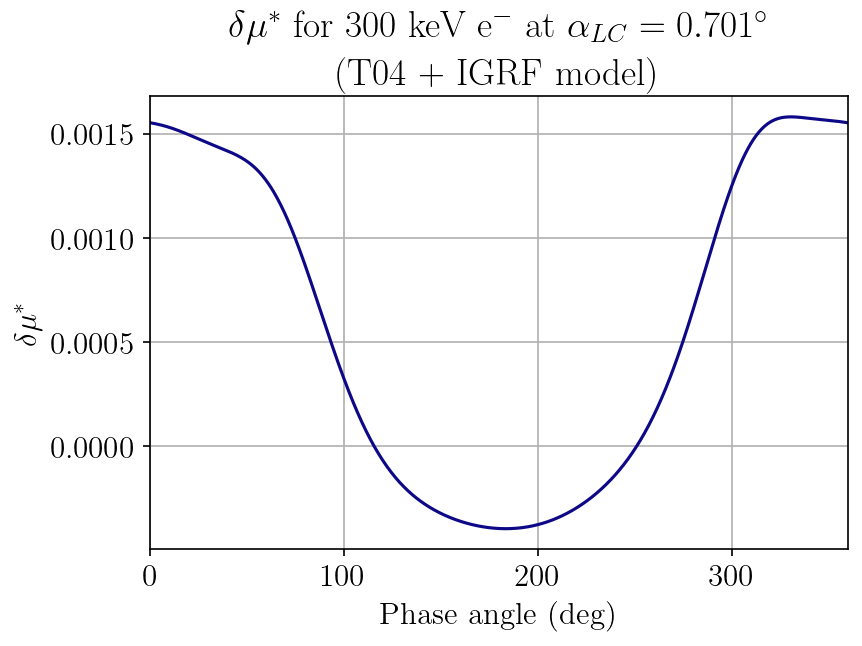

In [80]:
plt.plot(np.degrees(np.linspace(0, 2 * np.pi, 1000)), mu_final - mu_initial)
if model == 0:
    plt.title(f'$\delta\mu^*$ for ${E}$ keV e$^-$ at $\\alpha_{{LC}}={np.degrees(eq_loss_cone_ang):.3f}^\circ$\n(T04 + IGRF model)')
elif model == 1:
    plt.title(f'$\delta\mu^*$ for ${E}$ keV e$^-$ at $\\alpha_{{LC}}={np.degrees(eq_loss_cone_ang):.3f}^\circ$\n(Harris model)')
plt.ylabel(r'$\delta\mu^*$')
plt.xlabel('Phase angle (deg)')
plt.xlim([0, 360])
plt.grid()
plt.show()

In [58]:
dmu = mu_final - mu_initial
A_numerical = (np.amax(dmu) - np.amin(dmu)) / 2
print(f'The numerically found A value is: {A_numerical:.3e}')

The numerically found A value is: 9.881e-04


In [60]:
D_aa_num = A_numerical**2 / (2 * T_alpha(eq_loss_cone_ang) * np.sin(eq_loss_cone_ang)**2 * np.cos(eq_loss_cone_ang)**2)
lifetime_num = 1 / D_aa_num
print(f'The numerically found lifetime is: {lifetime_num:.3e} s')

The numerically found lifetime is: 3.299e+02 s


The Fokker-Planck diffusion equation relates the particle distribution function to the diffusion coefficient,

$$\frac{\partial f}{\partial t} = \frac{1}{\mathcal{T}_B\sin(2\alpha_0)}\frac{\partial}{\partial\alpha_0}\Big(\mathcal{T}_B\sin(2\alpha_0)D_{\alpha_0\alpha_0}\frac{\partial f}{\partial \alpha_0}\Big)$$

or

$$\frac{\partial f}{\partial t} = \frac{1}{\mathcal{T}_B\sin(2\alpha_0)}\Big[\frac{\partial}{\partial\alpha_0}\Big(\mathcal{T}_B\sin(2\alpha_0)D_{\alpha_0\alpha_0}\Big)\frac{\partial f}{\partial \alpha_0} + \Big(\mathcal{T}_B\sin(2\alpha_0)D_{\alpha_0\alpha_0}\Big)\frac{\partial^2 f}{\partial \alpha_0^2}\Big]$$

where

$$\mathcal{T}_B = \frac{4LR_E}{v}T(\alpha_0)$$

By separating variables, $f(\alpha_0, t) = h(\alpha_0)g(t)$, this becomes an eigenvalue problem. We can solve for the eigenvalues $-1/\tau$ and the eigenfunctions $h_\tau(t)$, $g_\tau(t)$ to get an expression for the total loss cone flux,

$$J(t) = -\frac{\mathrm{d}}{\mathrm{d}t}\Big(\int_{\alpha_{LC}}^{\alpha_{\text{max}}} f(\alpha_0, t)\,\mathrm{d}\alpha_0\Big) = -\frac{\mathrm{d}}{\mathrm{d}t}\Big(\int_{\alpha_{LC}}^{\alpha_{\text{max}}} \sum_i a_{\tau_i} h_{\tau_i}(\alpha_0)g_{\tau_i}(t)\,\mathrm{d}\alpha_0\Big) = \sum_i \frac{a_{\tau_i}}{\tau_i}g(t)\int_{\alpha_{LC}}^{\alpha_{\text{max}}}h(\alpha_0)\,\mathrm{d}\alpha_0$$

In [176]:
from scipy.integrate import simps
from scipy.integrate import solve_ivp

E = 300e3
gamma = E / (sp.m_e * sp.c**2) + 1.
v = sp.c * np.sqrt(1. - 1. / gamma**2)

eps = epsilon_general(E, -sp.e, sp.m_e, flc(b_field, rr[cs_ind]), np.linalg.norm(b_field(rr[cs_ind])))
z1, z2 = zetas_general(b_field, L)

In [177]:
steps = 3000
T = np.zeros((steps, steps))

for j, alpha in enumerate(np.linspace(0, np.pi/2, steps)):
    interior_quant = 2 * (0.5 * np.sin(alpha)**2 + F(eps, z1, z2, alpha) + A(eps, z1, z2, alpha) * np.cos(np.linspace(0, 2*np.pi, 1000)))
    no_nans = np.zeros_like(interior_quant)

    for i, q in enumerate(interior_quant):
        if q <= 0:
            no_nans[i] = 0
        elif q >= 1:
            no_nans[i] = 1
        else:
            no_nans[i] = np.degrees( np.arcsin(np.sqrt(q)) )

    T[:, j] = np.histogram(no_nans, bins=np.linspace(0, 90, steps + 1, endpoint=True), density=True)[0]
    T[:, j] /= np.sum(T[:, j])

In [182]:
alpha_i = 10
alpha_f = 80

P0 = np.zeros(steps)
P0[int(round((alpha_i / 90) * steps)):int(round((alpha_f / 90) * steps))] = 1
P0 = np.vstack(P0)
P0 /= (np.sum(P0) * (np.pi / 2) / steps)

In [183]:
T[:, 0:25] = 0.

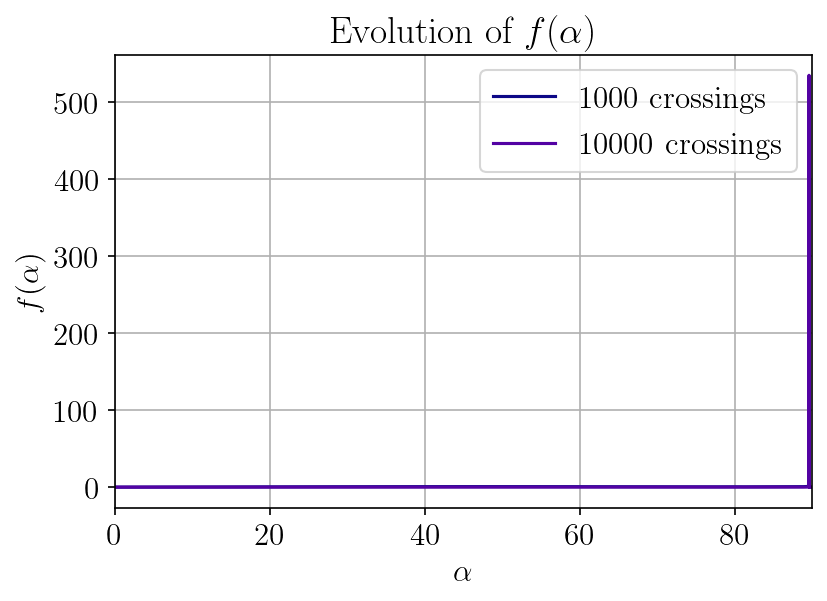

In [195]:
particles_lost = []

for i, power in enumerate([1000, 10000]): # enumerate(np.arange(0, 10000, 250)):
    new_dist = np.matmul(np.linalg.matrix_power(T, int(round(power))), P0)
    # particles_lost.append(1.0 - np.sum(new_dist) * (np.pi / 2) / steps)
    plt.plot(np.linspace(0, 90, steps), new_dist, c=f'C{2*i}', label=f'{power} crossings')
    
plt.xlim([0, 90])
plt.xlabel('$\\alpha$')
plt.ylabel('$f(\\alpha)$')

plt.title('Evolution of $f(\\alpha)$')

plt.grid()
plt.legend()
plt.show()

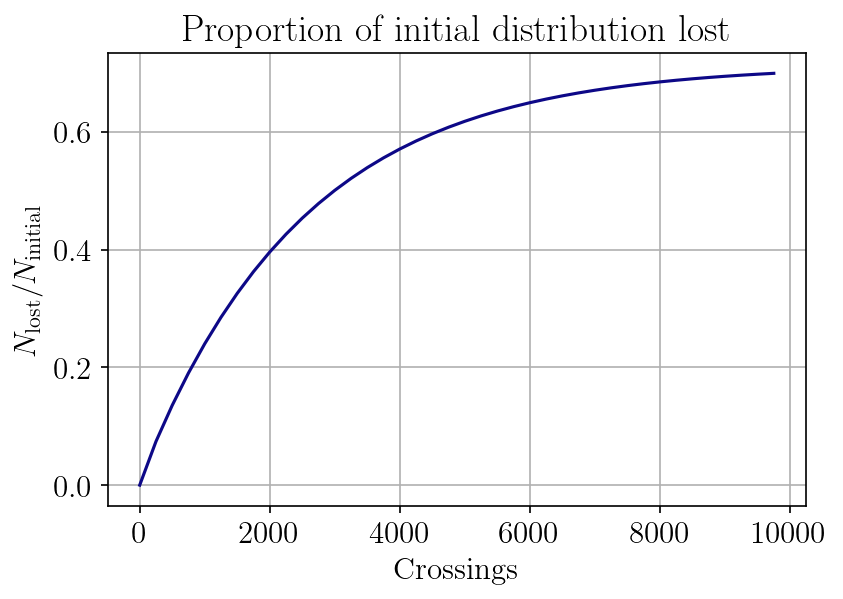

In [192]:
plt.plot(np.arange(0, 10000, 250), particles_lost)

plt.title('Proportion of initial distribution lost')
plt.xlabel('Crossings')
plt.ylabel('$N_{\mathrm{lost}}/N_{\mathrm{initial}}$')


plt.grid()
plt.show()

In [302]:
def pdf(alpha, alpha_i, A, F):
    if alpha < 0 or alpha > np.pi / 2:
        return 0
    
    alpha = np.pi - alpha
    
    B = (np.sin(alpha)**2 - np.sin(alpha_i)**2 - 2 * F)**2
    
    if B > (4 * A**2):
        return 0
    
    return -(2 / np.pi) * (np.sin(alpha) * np.cos(alpha)) / np.sqrt((4 * A**2) - B)

In [331]:
alpha = np.linspace(0, np.pi / 2, 400)
P_matrix = np.zeros((len(alpha), len(alpha)))

for i in range(len(alpha)):
    for j in range(len(alpha)):
        P_matrix[j, i] = pdf(alpha[j], alpha[i], A(eps, z1, z2, alpha[i]), F(eps, z1, z2, alpha[i]))
        
for j in range(len(alpha)):
    s = np.sum(P_matrix[:, j])
    if np.abs(s) > 0:
        P_matrix[:, j] /= s

In [334]:
P0 = np.vstack(np.ones(len(alpha)))

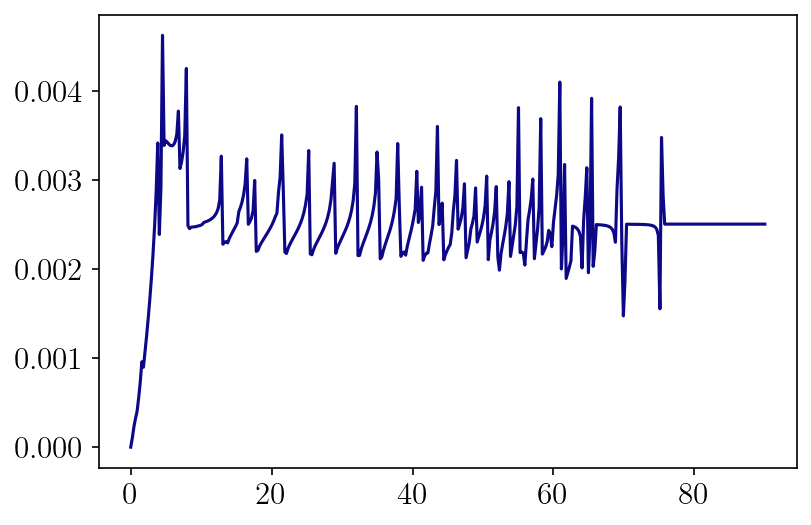

In [338]:
new_dist = np.matmul(P_matrix, P0)
new_dist /= np.sum(new_dist)

plt.plot(np.degrees(alpha), new_dist)

In [196]:
@njit
def T_B(alpha):
    return (4 * L_actual * Re / v) * T_alpha(alpha)

@njit
def D_a0a0(alpha):
    return D_aa(eps, z1, z2, alpha, T_alpha)

T_B0 = T_B(0)

In [76]:
@njit
def diff_func(f, x):
    eps = 1e-6
    return (f(x + eps) - f(x)) / eps

@njit
def m22_func(alpha):
    return np.log(T_B(alpha) * np.sin(2 * alpha) *  D_a0a0(alpha))

def int_fun(tau):
    @njit
    def fun(t, y):
        y_out = np.array([y[1], (-1 / (tau * D_a0a0(t))) * y[0] - diff_func(m22_func, t) * y[1]])
        return y_out
    return fun

@njit
def bc(ya, yb):
    return (ya[0], yb[1])

In [77]:
@njit
def DoPri45Step(f, t, x, h):
    k1 = f(t, x)
    k2 = f(t + 1. / 5 * h, x + h*(1./5*k1) )
    k3 = f(t + 3. / 10 * h, x + h*(3./40*k1 + 9./40*k2) )
    k4 = f(t + 4. / 5 * h, x + h*(44./45*k1 - 56./15*k2 + 32./9*k3) )
    k5 = f(t + 8. / 9 * h, x + h*(19372./6561*k1 - 25360./2187*k2 + 64448. / 6561*k3 - 212. / 729 * k4) )
    k6 = f(t + h, x + h * (9017. / 3168 * k1 - 355. / 33 * k2 + 46732. / 5247 * k3 + 49. / 176 * k4 - 5103. / 18656 * k5) )

    v5 = 35./384*k1 + 500./1113*k3 + 125./192*k4 - 2187./6784*k5 + 11./84*k6
    k7 = f(t + h, x + h*v5)
    v4 = 5179./57600*k1 + 7571./16695*k3 + 393./640*k4 - 92097./339200*k5 + 187./2100*k6 + 1./40*k7

    return v4, v5

@njit
def DoPri45integrate(f, t, x0):
    N = len(t)
    x = np.zeros((N, 2))
    x[0, :] = x0
    for k in range(N - 1):
        v4, v5 = DoPri45Step(f, t[k], x[k], t[k+1] - t[k])
        x[k + 1] = (x[k] + (t[k + 1] - t[k]) * v5)
    return x

In [169]:
solver_tol = 1e-8
alpha_max = 85
mini_steps = 3    # Must be greater than 2
deriv_tol = 1e-3  # Must be less than or equal to tau_tol
tau_tol = 1e-3

eq_loss_cone_ang = np.radians(5)

tau_min = 100
tau_max = 200

bcs = []

while np.abs(tau_min - tau_max) > tau_tol:
    print(f'Min. lifetime: {tau_min}, Max. lifetime: {tau_max}')
    
    tau_list = np.linspace(tau_min, tau_max, mini_steps, endpoint=True)
    
    if len(bcs) == 0:
        for tau in tau_list:
            sol = solve_ivp(int_fun(tau), [eq_loss_cone_ang, np.radians(alpha_max)], [0., 1.], method='RK45', rtol=solver_tol, atol=solver_tol, max_step=deriv_tol)
            end_bc = (sol.y[0][-1] - np.interp(np.radians((1 - deriv_tol) * alpha_max), sol.t, sol.y[0])) / (deriv_tol * np.radians(alpha_max))
            bcs.append(end_bc)
    else:
        for tau in tau_list[1:-1]:
            sol = solve_ivp(int_fun(tau), [eq_loss_cone_ang, np.radians(alpha_max)], [0., 1.], method='RK45', rtol=solver_tol, atol=solver_tol, max_step=deriv_tol)
            end_bc = (sol.y[0][-1] - np.interp(np.radians((1 - deriv_tol) * alpha_max), sol.t, sol.y[0])) / (deriv_tol * np.radians(alpha_max))
            bcs.insert(-1, end_bc)

    print(f'Boundary values: {bcs}')
    
    ind = np.argwhere(np.diff(np.sign(bcs)))[0, 0]
    
    tau_min = tau_list[ind]
    tau_max = tau_list[ind + 1]
    
    bcs = [bcs[ind], bcs[ind + 1]]
    
print(tau_min, tau_max)

Min. lifetime: 100, Max. lifetime: 200
Boundary values: [-1341.558290786385, -527.2700896822407, 1762.0233805220746]
Min. lifetime: 150.0, Max. lifetime: 200.0
Boundary values: [-527.2700896822407, 543.3170627828528, 1762.0233805220746]
Min. lifetime: 150.0, Max. lifetime: 175.0
Boundary values: [-527.2700896822407, -21.154837570647874, 543.3170627828528]
Min. lifetime: 162.5, Max. lifetime: 175.0
Boundary values: [-21.154837570647874, 255.6798187325368, 543.3170627828528]
Min. lifetime: 162.5, Max. lifetime: 168.75
Boundary values: [-21.154837570647874, 115.71190558232844, 255.6798187325368]
Min. lifetime: 162.5, Max. lifetime: 165.625
Boundary values: [-21.154837570647874, 46.86926808538346, 115.71190558232844]
Min. lifetime: 162.5, Max. lifetime: 164.0625
Boundary values: [-21.154837570647874, 12.752116409685074, 46.86926808538346]
Min. lifetime: 162.5, Max. lifetime: 163.28125
Boundary values: [-21.154837570647874, -4.227988140411995, 12.752116409685074]
Min. lifetime: 162.890625, 

In [165]:
tau0 = (166.49658203125 + 166.4971923828125) * 0.5
tau1 = 115.167236328125 # (115.167236328125 + 115.1678466796875) * 0.5

In [89]:
sol0 = solve_ivp(int_fun(tau0), [eq_loss_cone_ang, np.radians(alpha_max)], [0., 1.], method='RK45', rtol=solver_tol, atol=solver_tol, max_step=deriv_tol)
sol1 = solve_ivp(int_fun(tau1), [eq_loss_cone_ang, np.radians(alpha_max)], [0., 1.], method='RK45', rtol=solver_tol, atol=solver_tol, max_step=deriv_tol)

In [125]:
y0_area = simps(sol0.y[0]**2, sol0.t)
y1_area = simps(sol1.y[0]**2, sol1.t)

t0 = sol0.t
t1 = sol1.t

y0 = sol0.y[0] / np.sqrt(y0_area)
y1 = sol1.y[0] / np.sqrt(y1_area)

In [133]:
alpha_eqs = np.linspace(eq_loss_cone_ang, np.radians(alpha_max), 1500)
y0_interp = np.interp(alpha_eqs, t0, y0)
y1_interp = np.interp(alpha_eqs, t1, y1)

In [151]:
mid_func = np.log(T_B(alpha_eqs) * np.sin(2 * alpha_eqs) * D_a0a0(alpha_eqs))
dalpha = alpha_eqs[1] - alpha_eqs[0]

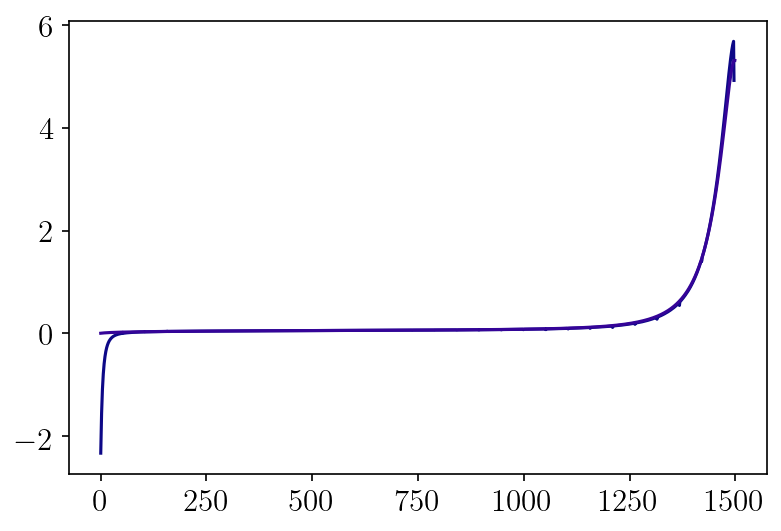

In [166]:
plt.plot(-tau0 * D_a0a0(alpha_eqs)[0:-2] * (np.diff(y0_interp, 2) / dalpha**2 + (np.diff(mid_func)[0:-1] / dalpha) * (np.diff(y0_interp, 1)[0:-1] / dalpha)))
plt.plot(y0_interp)

In [95]:
t_list = []
y_list = []
tau_list = []
proportion_list = []

In [123]:
def solve_tau(tau_min, tau_max, iteration=0, steps=500, alpha_max=85, tol=1e-7, rbc=None, lbc=None):
    if iteration > 50:
        print('Exceeded max iterations.')
        return None
    
    method = 'RK45'
    t_span = [eq_loss_cone_ang, np.radians(alpha_max)]
    # ts = np.linspace(eq_loss_cone_ang, np.radians(alpha_max), steps)
    y0 = np.array([0., 1.])
    
    end_bc_max = 0
    if rbc != None:
        end_bc_max = rbc
    else:
        sol = solve_ivp(int_fun(tau_max), t_span, y0, method=method, rtol=tol, atol=tol, max_step=1e-2)
        # end_bc_max = sol.y[1, -2]
        end_bc_max = (sol.y[0][-1] - sol.y[0][-2]) / (sol.t[-1] - sol.t[-2])
        
        # ys = DoPri45integrate(int_fun(tau_max), ts, y0)
        # end_bc_max = (ys[-1, 0] - ys[-2, 0]) / (ts[1] - ts[0])
    
    end_bc_min = 0
    if lbc != None:
        end_bc_min = lbc
    else:
        sol = solve_ivp(int_fun(tau_min), t_span, y0, method=method, rtol=tol, atol=tol, max_step=1e-2)
        # end_bc_min = sol.y[1, -2]
        end_bc_min = (sol.y[0][-1] - sol.y[0][-2]) / (sol.t[-1] - sol.t[-2])
        
        # ys = DoPri45integrate(int_fun(tau_min), ts, y0)
        # end_bc_min = (ys[-1, 0] - ys[-2, 0]) / (ts[1] - ts[0])
    
    print(f'Tau Difference: {np.abs(tau_max - tau_min):.3e}, BC Difference: {np.abs(end_bc_max - end_bc_min):.3e}')
    
    if np.sign(end_bc_min * end_bc_max) == 1 and np.abs(tau_min - tau_max) > tol:
        print('Change bounds of tau.')
        return tau_min, tau_max
    elif np.abs(tau_min - tau_max) <= tol:
        return sol.t, sol.y, (tau_min + tau_max) * 0.5
        # return ts, ys, (tau_min + tau_max) * 0.5
    else:
        tau_mid = (tau_max + tau_min) * 0.5
        
        tau = tau_mid
        sol = solve_ivp(int_fun(tau), t_span, y0, method=method, rtol=tol, atol=tol, max_step=1e-2)
        # end_bc_mid = sol.y[1, -2]
        end_bc_mid = (sol.y[0][-1] - sol.y[0][-2]) / (sol.t[-1] - sol.t[-2])
        
        # ys = DoPri45integrate(int_fun(tau_mid), ts, y0)
        # end_bc_mid = (ys[-1, 0] - ys[-2, 0]) / (ts[1] - ts[0])
        
        if np.sign(end_bc_mid * end_bc_min) != 1:
            return solve_tau(tau_min, tau_mid, iteration + 1, rbc=end_bc_mid)
        elif np.sign(end_bc_mid * end_bc_max):
            return solve_tau(tau_mid, tau_max, iteration + 1, lbc=end_bc_mid)
    
    return
    
t, y, tau = solve_tau(160, 180, steps=400, tol=1e-4, alpha_max=85)

Tau Difference: 2.000e+01, BC Difference: 6.579e+01
Tau Difference: 1.000e+01, BC Difference: 3.049e+01
Tau Difference: 5.000e+00, BC Difference: 1.800e+01
Tau Difference: 2.500e+00, BC Difference: 1.471e+01
Tau Difference: 1.250e+00, BC Difference: 9.185e+00
Tau Difference: 6.250e-01, BC Difference: 9.030e+00
Tau Difference: 3.125e-01, BC Difference: 2.046e+00
Tau Difference: 1.562e-01, BC Difference: 5.488e+00
Tau Difference: 7.812e-02, BC Difference: 1.391e+00
Tau Difference: 3.906e-02, BC Difference: 8.884e+00
Tau Difference: 1.953e-02, BC Difference: 8.511e+00
Tau Difference: 9.766e-03, BC Difference: 5.956e+00
Tau Difference: 4.883e-03, BC Difference: 5.813e+00
Tau Difference: 2.441e-03, BC Difference: 5.750e+00
Tau Difference: 1.221e-03, BC Difference: 5.748e+00
Tau Difference: 6.104e-04, BC Difference: 5.492e+00
Tau Difference: 3.052e-04, BC Difference: 5.381e+00
Tau Difference: 1.526e-04, BC Difference: 6.192e+00
Tau Difference: 7.629e-05, BC Difference: 1.093e+00
Tau Differen

In [124]:
tau

165.59690456837416

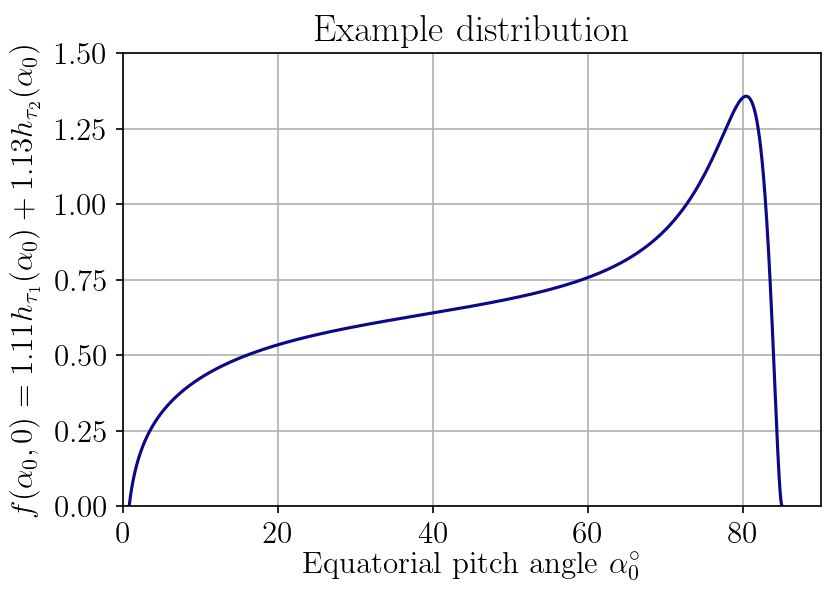

In [260]:
from scipy import interpolate

e_tck = []

for j in range(len(tau_list)):
    e_tck.append(interpolate.splrep(t_list[j], y_list[j], s=0))

x_n = np.linspace(eq_loss_cone_ang, np.radians(85), 5000)

y_n = []

for j in range(len(tau_list)):
    y_n.append(interpolate.splev(x_n, e_tck[j], der=0))

groups = []

for j in range(int(len(tau_list) / 2)):
    groups.append(y_n[2 * j] + y_n[2 * j + 1] * np.abs(y_n[2 * j][-1] / y_n[2 * j + 1][-1]))

dx = x_n[1] - x_n[0]

a1 = 1
a2 = 0 # 1e-1
a3 = 0 # 1e-2 # 4e-2

plt.plot(np.degrees(x_n), a_1 * y_n[0] + a_2 * y_n[1])# a1 * groups[0] + a2 * groups[1] + a3 * groups[2], c=f'C{5*i}')

plt.xlim([0, 90])
plt.xlabel('Equatorial pitch angle $\\alpha_0^\circ$')
plt.ylim([0, 1.5])
plt.ylabel(f'$f(\\alpha_0, 0) = {a_1:.2f}h_{{\\tau_1}}(\\alpha_0) + {a_2:.2f}h_{{\\tau_2}}(\\alpha_0)$')
plt.title('Example distribution')

plt.grid()
plt.show()

In [233]:
area = np.sum(a1 * groups[0]) * dx

In [234]:
a1 /= area

In [243]:
a_1 = a1
a_2 = a1 * np.abs(y_n[0][-1] / y_n[1][-1])

In [249]:
(a_1 / tau_list[0]) * np.sum(y_n[0]) * dx + (a_2 / tau_list[1]) * np.sum(y_n[1]) * dx

0.0074105648296488285

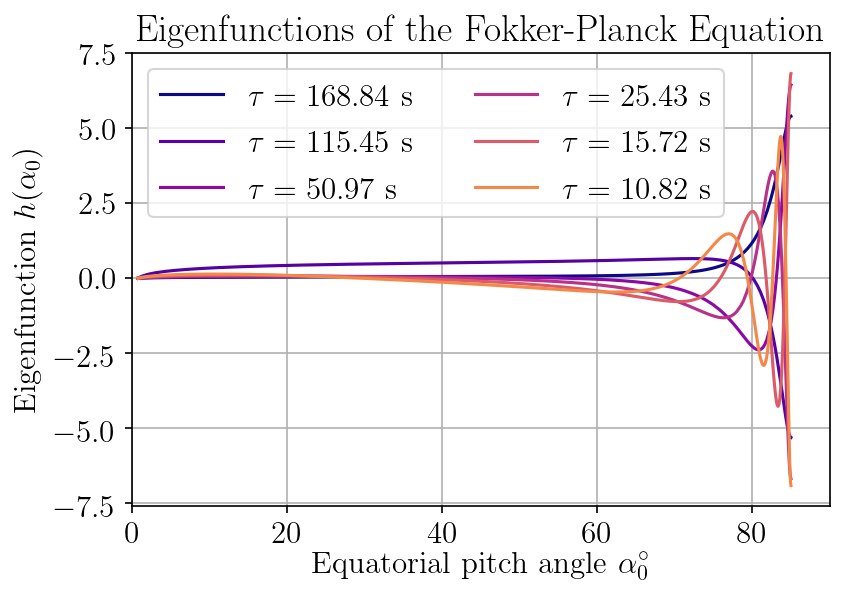

In [230]:
for i, tau in enumerate(tau_list):
    plt.plot(np.degrees(t_list[i]), y_list[i], c=f'C{2*i}', label=f'$\\tau = {tau:.2f}$ s')

plt.xlim([0, 90])
plt.xlabel('Equatorial pitch angle $\\alpha_0^\circ$')
plt.ylabel('Eigenfunction $h(\\alpha_0)$')
plt.title('Eigenfunctions of the Fokker-Planck Equation')
    
plt.legend(ncol=2)
plt.grid()
plt.show()

In [58]:
an = []

for i in range(len(tau_list)):
    an.append(simps(y_list[i], t_list[i]))

0.4582384552457895
0.32899804003609734
0.25056689419917144
0.19449617731470423
0.15224504960039145
0.11974529519674593
0.09450169854043348
0.07478359409251394
0.05932123872924054
0.04715844064735708


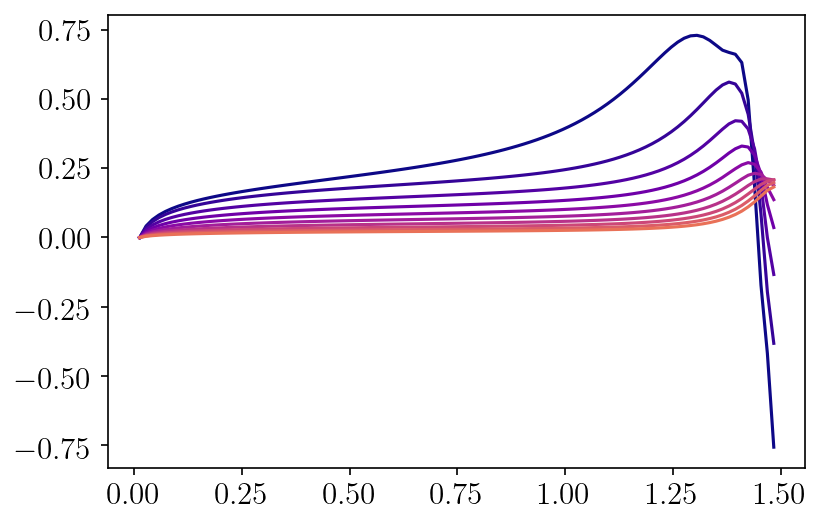

In [63]:
alpha_eqs = np.linspace(eq_loss_cone_ang, np.radians(85), 100)


for j in np.linspace(0, 300, 10):
    fs = np.zeros_like(alpha_eqs)
    
    for i in range(len(tau_list)):
        fs += an[i] * np.interp(alpha_eqs, t_list[i], y_list[i]) * np.exp(-j / tau_list[i])

    print(np.sum(fs) * (alpha_eqs[1] - alpha_eqs[0]))
    plt.plot(alpha_eqs, fs)
    
plt.show()

In [76]:
flux = 0
t = 50

for i in range(len(tau_list)):
    flux += an[i] / tau_list[i] * np.exp(-t / tau_list[i])
    
print(f'Flux at t = {t}: {flux}')

Flux at t = 50: 0.002190502995930329


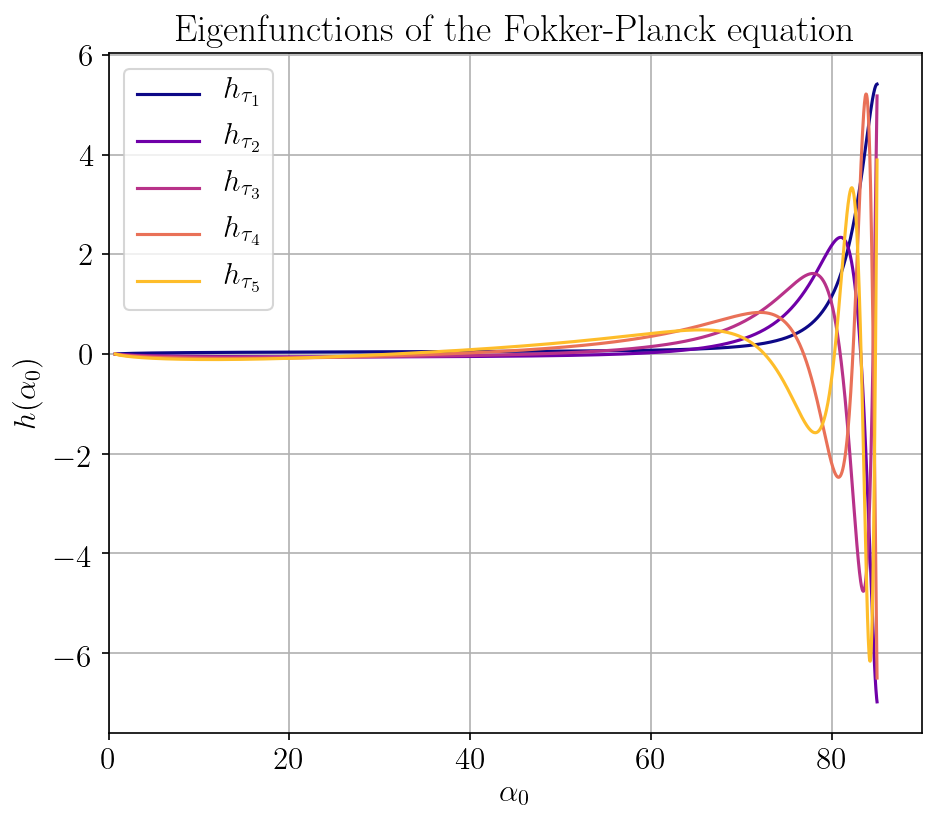

In [232]:
format_plots()

plt.figure(figsize=(7, 6))

for i in range(5):
    plt.plot(np.degrees(x), ys[i], c=f'C{3*i}', label=f'$h_{{\\tau_{i + 1}}}$')

plt.xlim([0, 90])
plt.xlabel('$\\alpha_0$')
plt.ylabel('$h(\\alpha_0)$')
plt.title('Eigenfunctions of the Fokker-Planck equation')
    
plt.legend()
plt.grid()
plt.show()

In [162]:
def y_test(t, weight):
    sn = np.zeros(x.size)
    for i in range(len(tau_list)):
        sn += weight[i] * ys[i] * np.exp(-t / tau_list[i])
    return sn

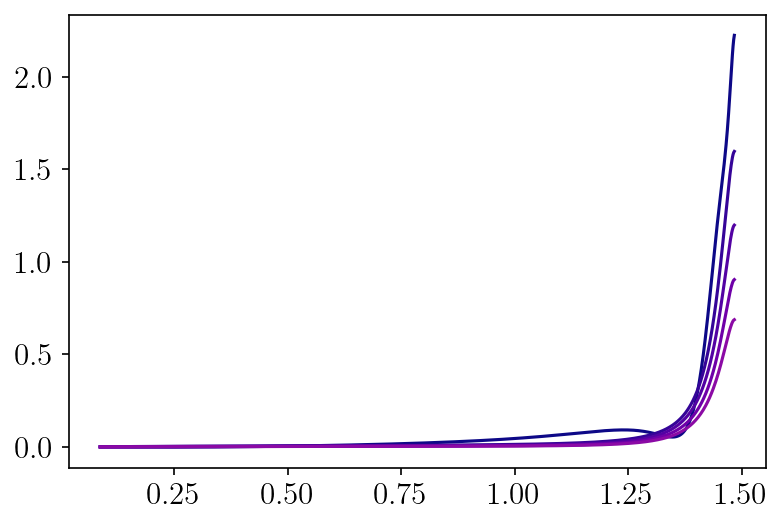

In [167]:
for i in np.arange(0, 200, 40):
    plt.plot(x, y_test(i, am))
plt.show()

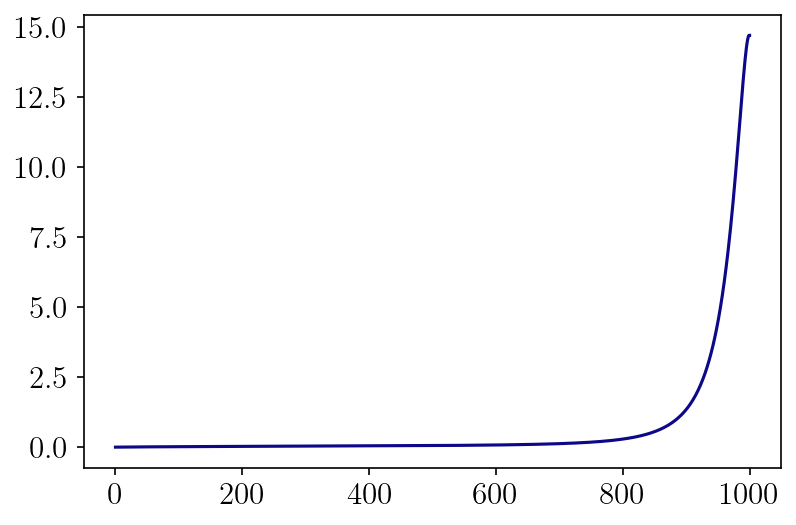

In [97]:
plt.plot(ys[3])